In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from torch.autograd import grad
from src.nonconvex import sgd, create_proj_fn, create_loss_fn
from src.utils import extract_measurement, create_P, PSSE_initialization, same_seed, load_mat_data, create_mask, print_busses
from src.search import create_search_loss_fn, create_search_proj_fn, search
from src.verify import check_PSSE

In [2]:
p1_r = np.array([
    [1.0, 0.0],
    [0.0, 0.0]
])
p1_i = np.array([
    [0.0, 0.0],
    [0.0, 0.0]
])
p2_r = np.array([
    [0, -50/101],
    [-50/101, 100/101]
])
p2_i = np.array([
    [0, -500/101],
    [500/101, 0]
])
p3_r = np.array([
    [0, -50/101],
    [50/101, 0]
])
p3_i = np.array([
    [0, -500/101],
    [-500/101, 1000/101]
])
p4_r = np.array([
    [100/101, -50/101],
    [-50/101, 0]
])
p4_i = np.array([
    [0, 500/101],
    [-500/101, 0]
])
bus2_mats = [(p1_r, p1_i, True), (p2_r, p2_i, True), (p3_r, p3_i, False), (p4_r, p4_i, True)]

In [4]:
def plot_loss(losses):
    fig, ax = plt.subplots(3, 2, figsize=(20, 30), tight_layout=True)
    loss    = [loss[0] for loss in losses]
    diff    = [-loss[1] for loss in losses]
    grad_X  = [loss[2] for loss in losses]
    hess_X  = [loss[3] for loss in losses]
    f_X     = [loss[4] for loss in losses]
    f_Z     = [loss[5] for loss in losses]
    trans   = [loss[6] for loss in losses]
    
    ax[0][0].plot(loss)
    ax[0][1].plot(diff)
    ax[1][0].plot(grad_X)
    ax[1][1].plot(trans)
    ax[2][0].plot(hess_X)
    ax[2][1].plot(f_X, label=r'f(X)')
    ax[2][1].plot(f_Z, label=r'f(Z)')

    ax[0][0].set_xlabel("# of GD Updates", fontsize=30), 
    ax[0][0].set_ylabel(r"$g(X,Z,E)$", fontsize=30)
    ax[0][0].set_title(f"Total Loss vs. # of GD Updates", fontsize=25, fontname='Comic Sans MS')
    ax[0][0].xaxis.set_tick_params(labelsize=20)
    ax[0][0].yaxis.set_tick_params(labelsize=20)
    ax[0][0].set_yscale('log')
    ax[0][0].grid()

    ax[0][1].set_xlabel("# of GD Updates", fontsize=30), 
    ax[0][1].set_ylabel(r"$f(X)-f(Z)$", fontsize=30)
    ax[0][1].set_title(r"$f(X)-f(Z)$ vs. # of GD Updates", fontsize=25, fontname='Comic Sans MS')
    ax[0][1].xaxis.set_tick_params(labelsize=20)
    ax[0][1].yaxis.set_tick_params(labelsize=20)
    ax[0][1].set_yscale('log')
    ax[0][1].grid()

    ax[1][0].set_xlabel("# of GD Updates", fontsize=30), 
    ax[1][0].set_ylabel(r"$\|\nabla_Xf(X)\|_F$", fontsize=30)
    ax[1][0].set_title(r"$\|\nabla_Xf(X)\|_F$ vs. # of GD Updates", fontsize=25, fontname='Comic Sans MS')
    ax[1][0].xaxis.set_tick_params(labelsize=20)
    ax[1][0].yaxis.set_tick_params(labelsize=20)
    ax[1][0].set_yscale('log')
    ax[1][0].grid()

    ax[1][1].set_xlabel("# of GD Updates", fontsize=30), 
    ax[1][1].set_ylabel(r"$-\|X-Z\|_2^2$", fontsize=30)
    ax[1][1].set_title(r"$-\|X-Z\|_2^2$ vs. # of GD Updates", fontsize=25, fontname='Comic Sans MS')
    ax[1][1].xaxis.set_tick_params(labelsize=20)
    ax[1][1].yaxis.set_tick_params(labelsize=20)
    ax[1][1].grid()

    ax[2][0].set_xlabel("# of GD Updates", fontsize=30), 
    ax[2][0].set_ylabel(r"$-\lambda_{min}(\nabla^2_Xf(X))$", fontsize=30)
    ax[2][0].set_title(r"$-\lambda_{min}(\nabla^2_Xf(X))$ vs. # of GD Updates", fontsize=25, fontname='Comic Sans MS')
    ax[2][0].xaxis.set_tick_params(labelsize=20)
    ax[2][0].yaxis.set_tick_params(labelsize=20)
    ax[2][0].set_yscale('log')
    ax[2][0].grid()

    ax[2][1].set_xlabel("# of GD Updates", fontsize=30), 
    ax[2][1].set_ylabel("Function Value", fontsize=30)
    ax[2][1].set_title("Function Value vs. # of GD Updates", fontsize=25, fontname='Comic Sans MS')
    ax[2][1].xaxis.set_tick_params(labelsize=20)
    ax[2][1].yaxis.set_tick_params(labelsize=20)
    # ax[2][1].set_yscale('log')
    ax[2][1].legend(loc='best')
    ax[2][1].set_yscale('log')
    ax[2][1].grid()

In [5]:
def search_counter(variables, top_k, e_norm, A, loss_type='PSSE_max', optim='Adam', iters=100, lr=0.001, min_lr=5e-5, lr_sched='cosine', T=1, trans_bound=(-1, -1e-2)):
    # x_0 = PSSE_initialization(z, 1.0)
    # x = torch.tensor(np.concatenate([x_0.real, x_0.imag]), requires_grad=True, dtype=torch.float64)
    parameters = {}
    for name, val  in variables.items():
        if name == 'X':
            gaussian_vector = torch.normal(0.0, torch.ones((A[0].size(0)),1)).to(torch.float64)
            X = gaussian_vector # / torch.linalg.norm(gaussian_vector, ord=torch.inf)
            X.requires_grad_()
            parameters['X'] = X
        elif name == 'Z':
            if val is None:
                Z = torch.normal(0.0, torch.ones((A[0].size(0)),1)).to(torch.float64).requires_grad_()
                parameters['Z'] = Z
            else:
                Z = torch.tensor(np.concatenate([val.real, val.imag[1:]]), dtype=torch.float64)
                # Z = torch.tensor(np.concatenate([val.real, val.imag]), dtype=torch.float64)
        elif name == 'e':
            if val is None:
                e = torch.zeros(len(A), requires_grad=True, dtype=torch.float64)
                parameters['e'] = e
            else:
                e = torch.zeros(len(A), requires_grad=False, dtype=torch.float64)
        elif name == 'P':
            if val is None:
                P = torch.rand(A.size(0), requires_grad=True, dtype=torch.float64)
                parameters['P'] = P
            else:
                P = val
    loss_fn = create_loss_fn(
        'PSSE', 
        P = P.detach(), 
        Z = Z.detach(), 
        e = e.detach(),
        top_k = top_k,
        A = A,
    )
    criterion = create_search_loss_fn(
        loss_fn, 
        loss_type, 
        P = P.detach(),
        Z = Z.detach(), 
        e = e.detach(),
    )
    proj_fn = create_search_proj_fn('PSSE', max_norm=e_norm)
    proj_fn(**parameters)
    losses = search(
        parameters,
        criterion,
        proj_fn,
        optim,
        iters,
        lr,
        min_lr,
        lr_sched,
        T,
        trans_bound
    )

    # z_rect.requires_grad_(True)
    # z_rect_n = torch.tensor(-np.concatenate([z.real, z.imag]), requires_grad=True, dtype=torch.float64).to(device)
    # print(torch.linalg.matrix_norm(grad(loss_fn(parameters[0], parameters[-1]), parameters[0])[0]).item())
    # print(torch.linalg.matrix_norm(grad(loss_fn(z_rect, parameters[-1]), z_rect)[0]).item())
    # print(torch.linalg.matrix_norm(grad(loss_fn(z_rect_n, parameters[-1]), z_rect_n)[0]).item())
    return parameters, losses

/var/folders/ch/s7cstp8x37ngmczcfl08zqxr0000gn/T/ipykernel_4902/2516076456.py:55: UserWarning: Data has no positive values, and therefore cannot be log-scaled.  
  ax[2][0].set_yscale('log')


==================== Search for (X) ====================
=> X
Bus-0: mag=0.8000, ang=0.0000
Bus-1: mag=0.8000, ang=-89.9981


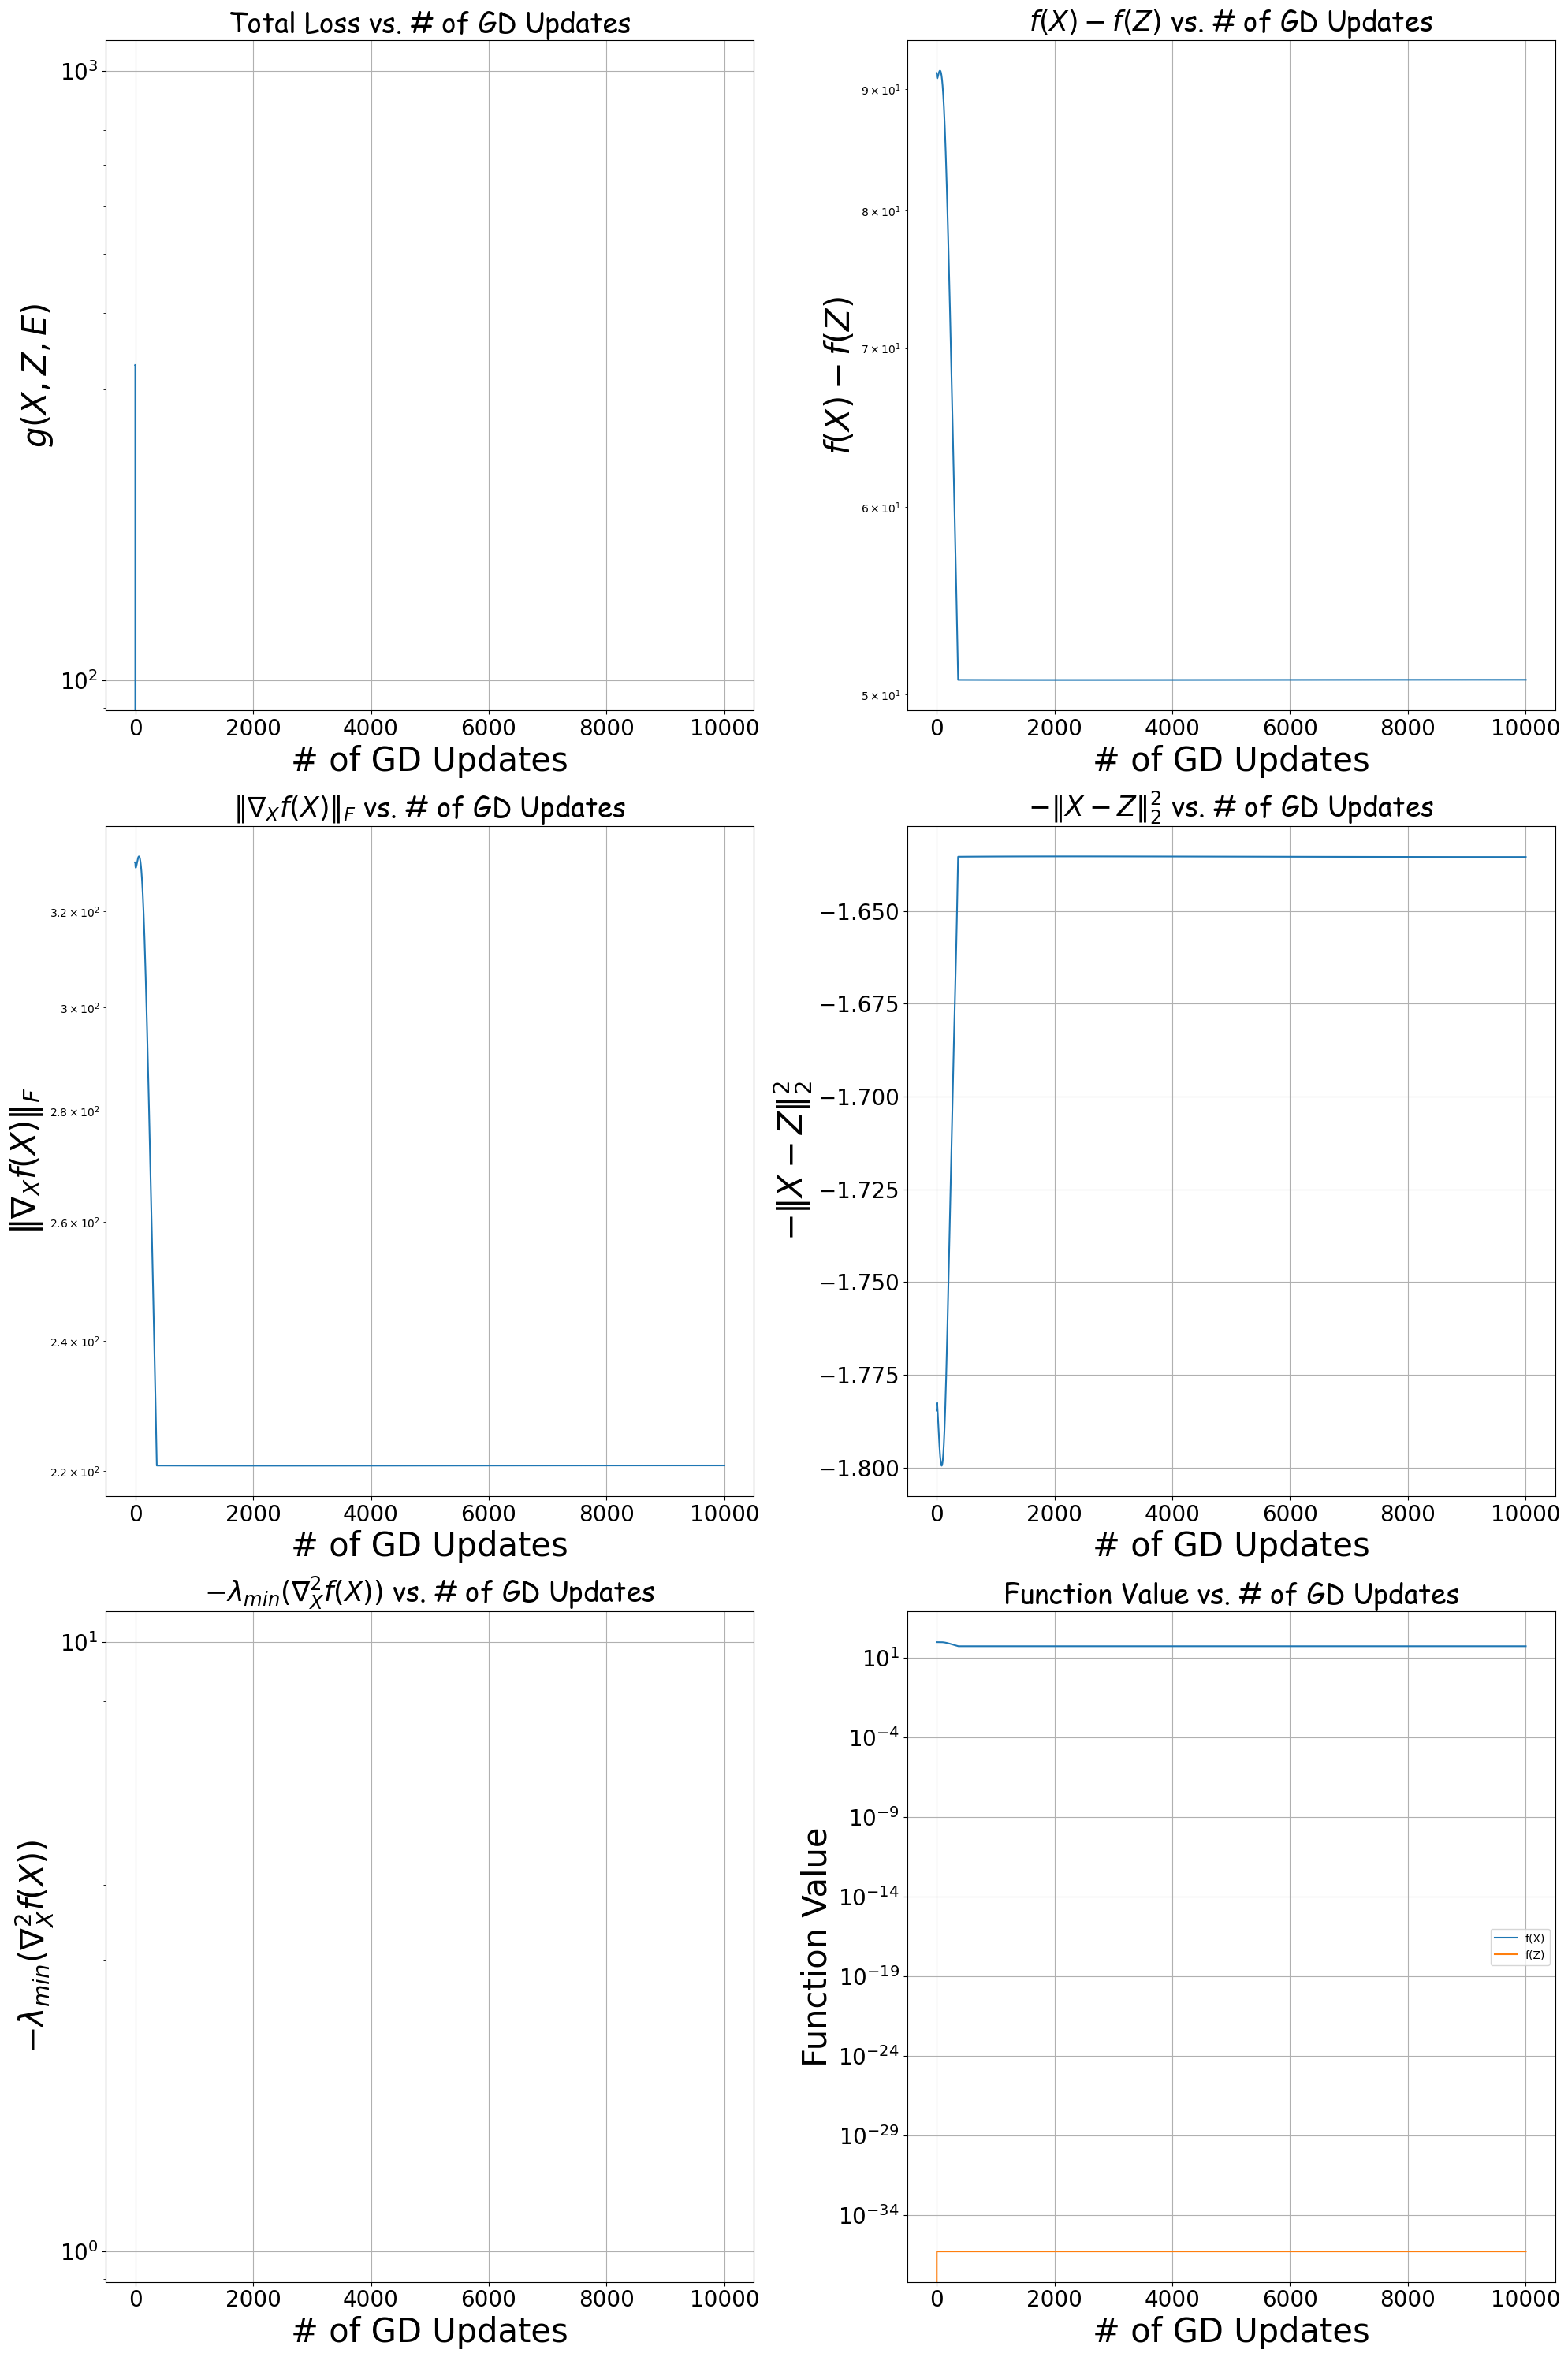

In [5]:
####### 2-bus Example (only search for X) #######
top_k       = 4        # 1 ~ 10
e_norm      = 1e-18
device      = 'cuda:0' if torch.cuda.is_available() else 'cpu'
loss_type   = 'PSSE_max'
optim       = 'Adam'
iters       = 10000
lr          = 5e-4
min_lr      = 5e-5
lr_sched    = 'cosine'
T           = 4
trans_bound = (-1, -5e1)

same_seed(0)
A_np = load_mat_data("data/2bus_data.mat")
A = torch.tensor(np.moveaxis(A_np.reshape(3,3,10), -1, 0), dtype=torch.float64)
# A_ext = torch.zeros((10,4,4), dtype=torch.float64)
# A_ext[:,:2,:2] = A[:,:2,:2]
# A_ext[:,3,:2] = A[:,2,:2]
# A_ext[:,:2,3] = A[:,:2,2]
# A_ext[:,3:,3:] = A[:,2:,2:]
# print(A_ext)
Z = np.array([1.0+0.0j, 0.8071-0.1893j]).reshape((2, 1))
# counter_Z = torch.tensor([0.87, 0.2802, -0.2013], dtype=torch.float64).reshape((3,1))
P = torch.tensor([1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0], dtype=torch.float64)
variables = {
    "X": None,
    "Z": Z,
    "e": None,
    "P": P,
}

parameters, losses = search_counter(
    variables,
    top_k, 
    e_norm, 
    A,
    loss_type, 
    optim, 
    iters, 
    lr, 
    min_lr,
    lr_sched, 
    T,
    trans_bound
)
print_busses("Search for (X)", parameters)
plot_loss(losses)

==================== Search for (X, Z) ====================
=> X
Bus-0: mag=0.8019, ang=0.0000
Bus-1: mag=0.8209, ang=-89.9999
=> Z
Bus-0: mag=0.8409, ang=0.00
Bus-1: mag=1.2000, ang=-40.64


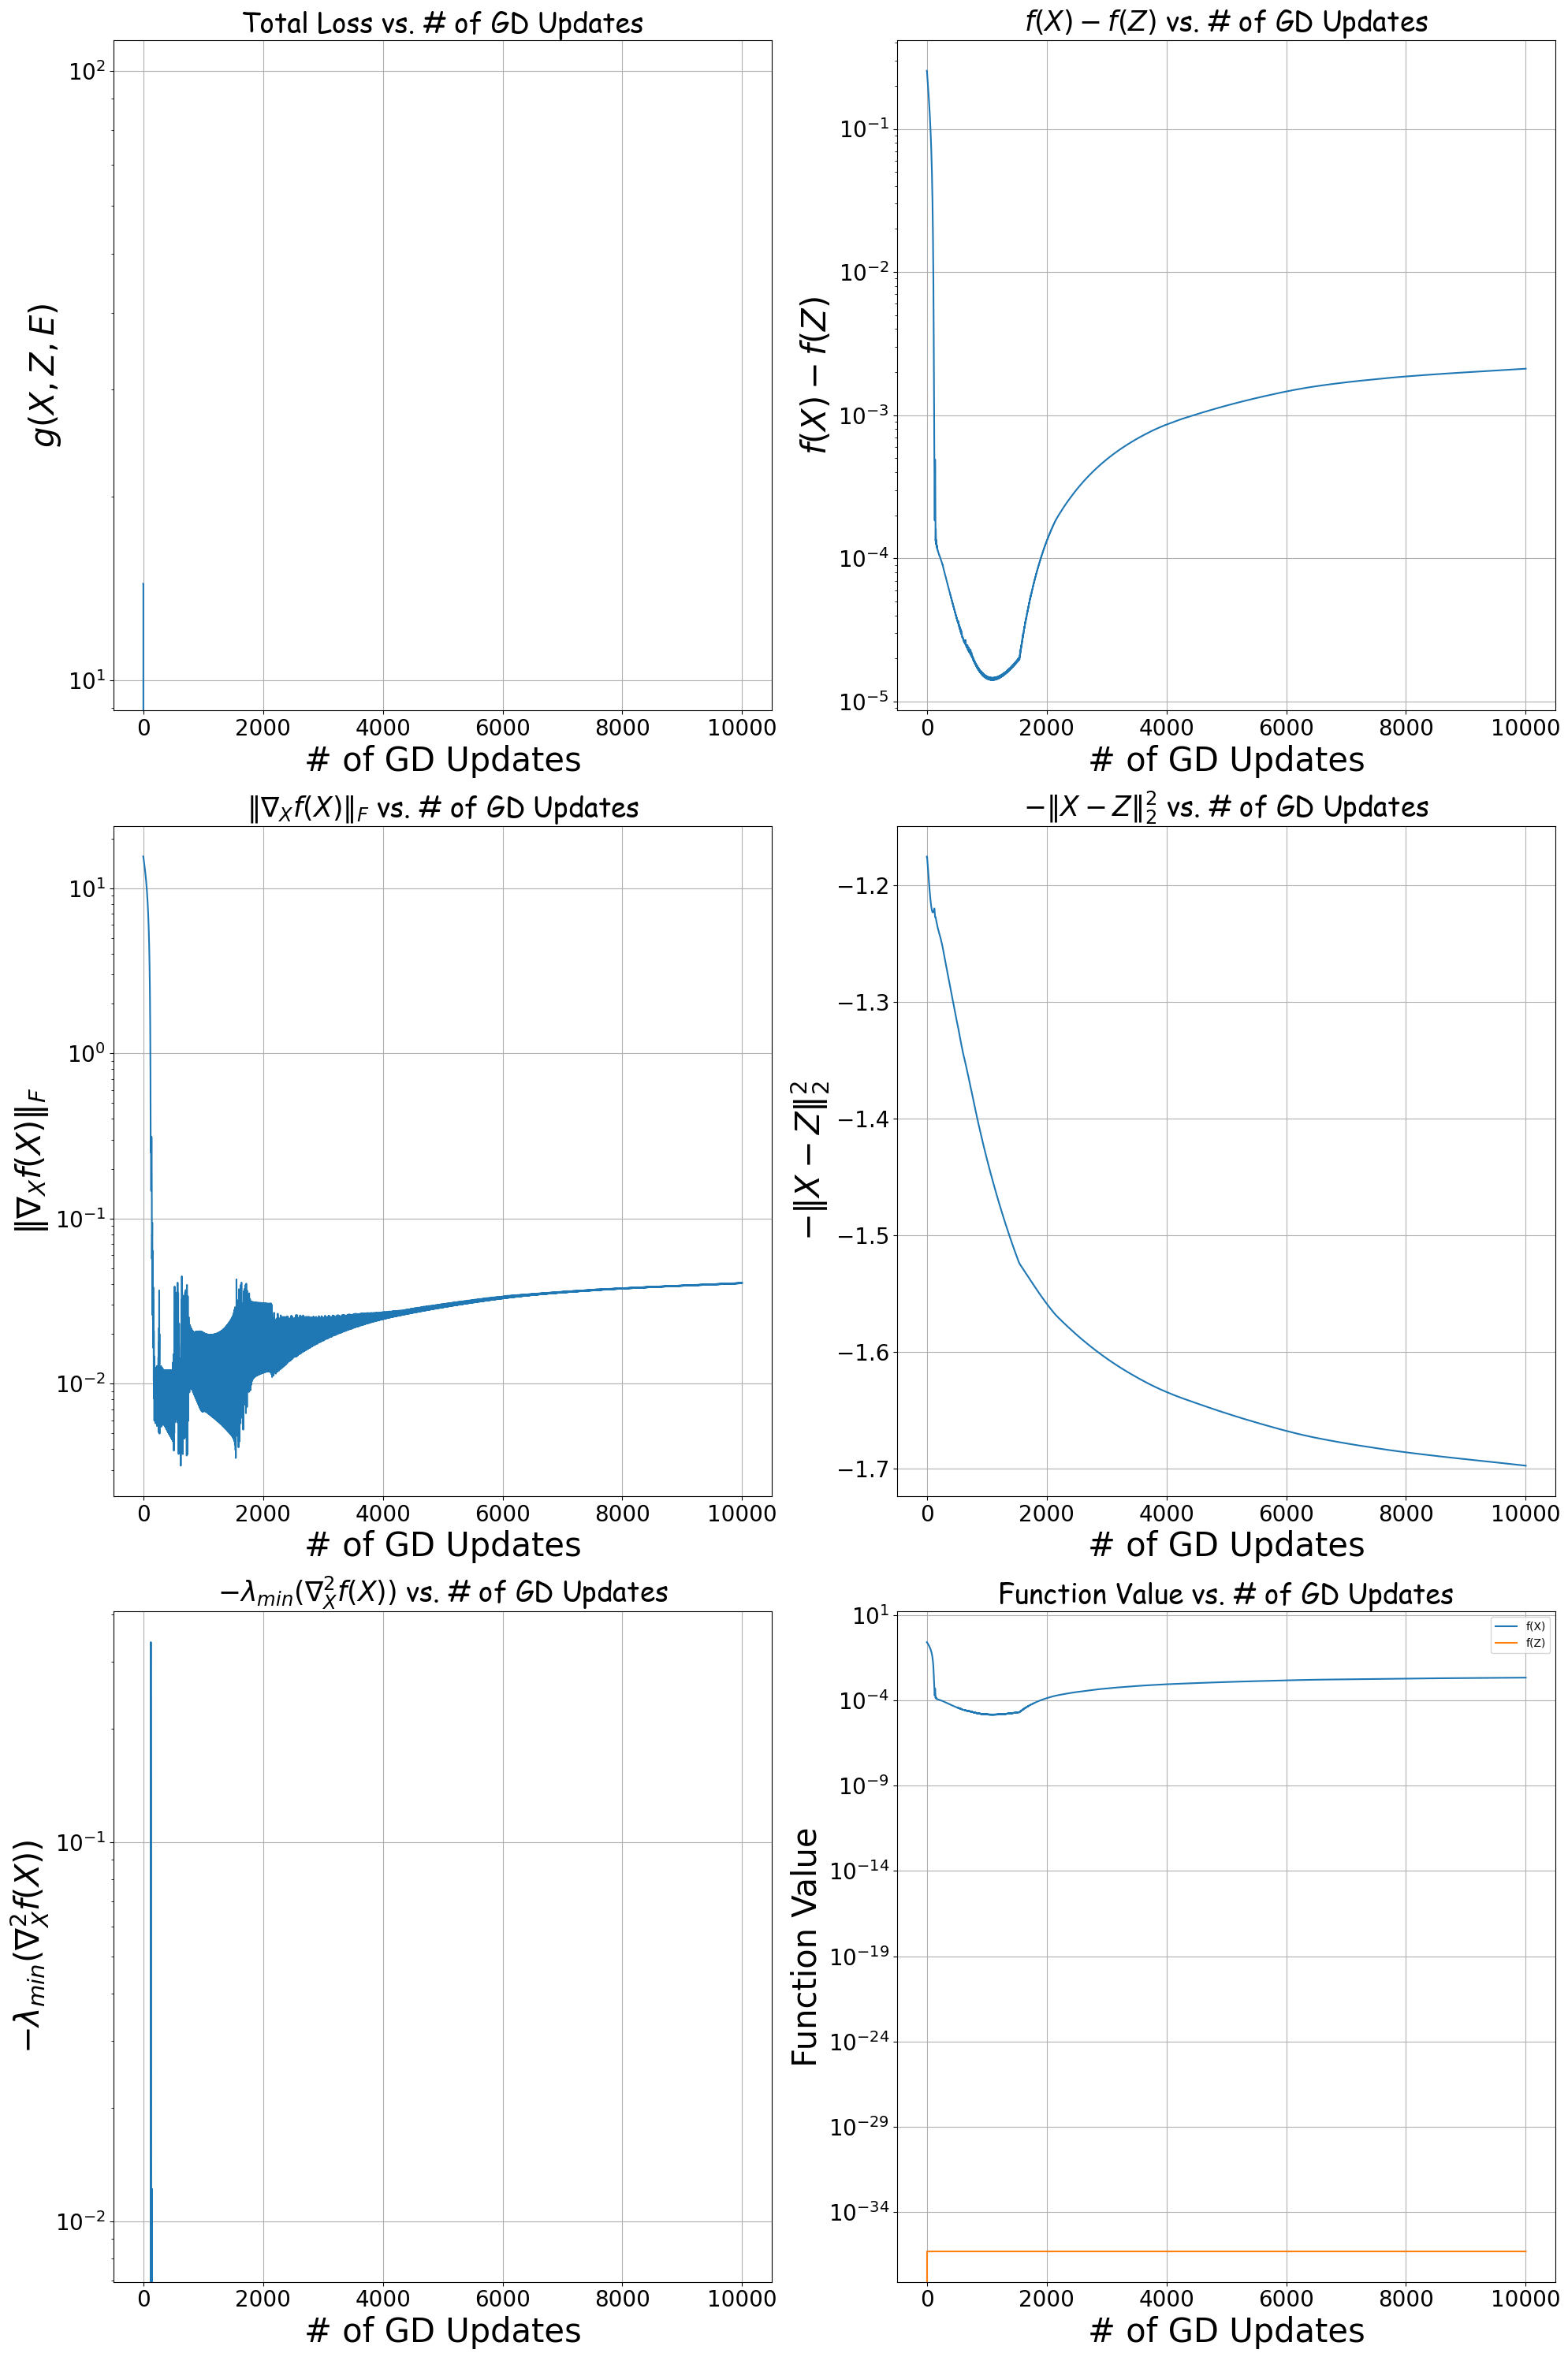

In [7]:
####### 2-bus Example (Search for X, Z) #######
top_k       = 3        # 1 ~ 10
e_norm      = 1e-18 
device      = 'cuda:0' if torch.cuda.is_available() else 'cpu'
loss_type   = 'PSSE_max'
optim       = 'Adam'
iters       = 10000
lr          = 3e-4
min_lr      = 5e-5
lr_sched    = 'cosine'
T           = 1.5
trans_bound = (-0.1, -5e1)

same_seed(0)
A_np = load_mat_data("data/2bus_data.mat")
A = torch.tensor(np.moveaxis(A_np.reshape(3,3,10), -1, 0), dtype=torch.float64)
# Z = np.array([1.0+0.0j, 0.8071-0.1893j]).reshape((2, 1))
P = torch.tensor([1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0], dtype=torch.float64)
variables = {
    "X": None,
    "Z": None,
    "e": None,
    "P": P,
}

parameters, losses = search_counter(
    variables,
    top_k, 
    e_norm, 
    A,
    loss_type, 
    optim, 
    iters, 
    lr, 
    min_lr,
    lr_sched, 
    T,
    trans_bound
)
print_busses("Search for (X, Z)", parameters)
plot_loss(losses)

==================== Search for (X, Z, P) ====================
=> X
Bus-0: mag=0.8000, ang=0.0000
Bus-1: mag=0.8545, ang=-77.0452
=> Z
Bus-0: mag=1.2000, ang=0.00
Bus-1: mag=1.2000, ang=-50.90
=> P
tensor([0.1786, 0.2610, 0.2609, 0.2587, 0.2610, 0.1768, 0.2596, 0.3819, 0.2593,
        0.2610], dtype=torch.float64)


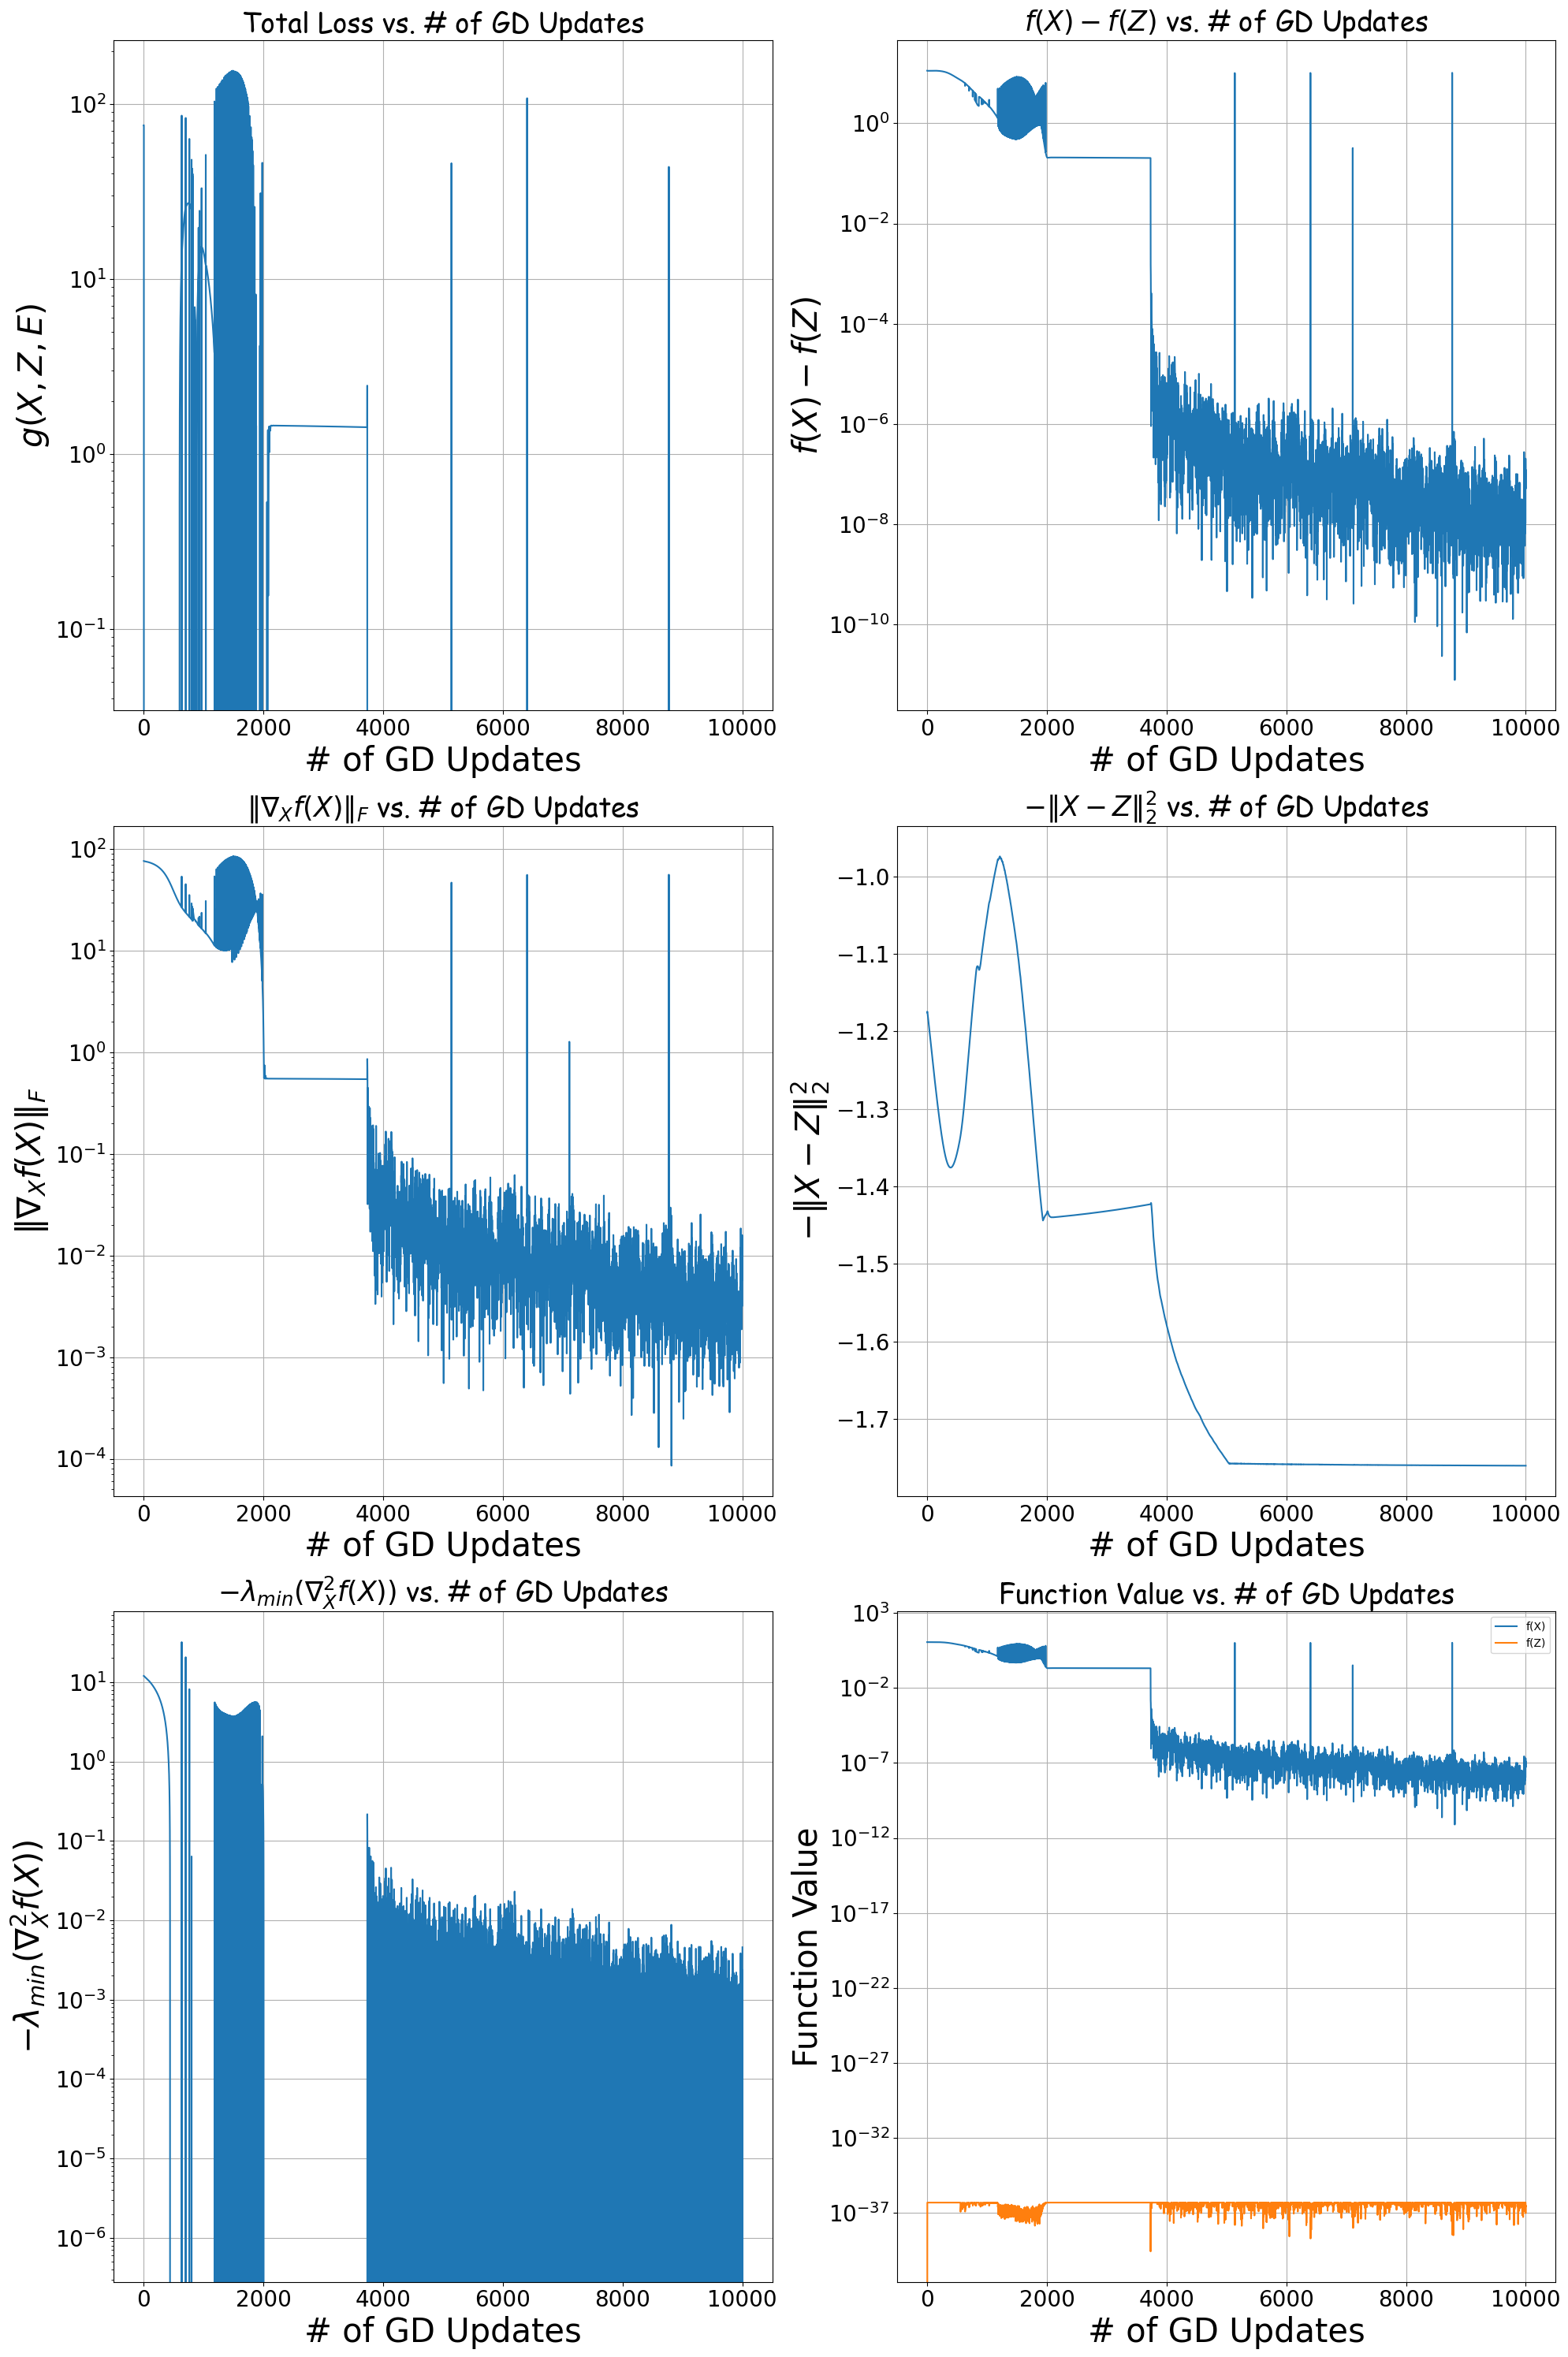

In [8]:
####### 2-bus Example (Search for X, Z, P) #######
top_k       = 3        # 1 ~ 10
e_norm      = 1e-18 
device      = 'cuda:0' if torch.cuda.is_available() else 'cpu'
loss_type   = 'PSSE_max'
optim       = 'Adam'
iters       = 10000
lr          = 3e-4
min_lr      = 5e-5
lr_sched    = 'cosine'
T           = 1.5
trans_bound = (-0.1, -5e1)

same_seed(0)
A_np = load_mat_data("data/2bus_data.mat")
A = torch.tensor(np.moveaxis(A_np.reshape(3,3,10), -1, 0), dtype=torch.float64)
# Z = np.array([1.0+0.0j, 0.8071-0.1893j]).reshape((2, 1))
# P = torch.tensor([1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0], dtype=torch.float64)
variables = {
    "X": None,
    "Z": None,
    "e": None,
    "P": None,
}

parameters, losses = search_counter(
    variables,
    top_k, 
    e_norm, 
    A,
    loss_type, 
    optim, 
    iters, 
    lr, 
    min_lr,
    lr_sched, 
    T,
    trans_bound
)
print_busses("Search for (X, Z, P)", parameters)
plot_loss(losses)

==================== 14-bus Example (Search for X, Z, P) ====================
=> X
Bus-0: mag=0.8000, ang=0.0000
Bus-1: mag=0.8000, ang=32.2161
Bus-2: mag=1.2000, ang=-35.7634
Bus-3: mag=0.8000, ang=-82.1594
Bus-4: mag=0.8111, ang=0.2546
Bus-5: mag=0.8000, ang=-25.8903
Bus-6: mag=0.8266, ang=4.1647
Bus-7: mag=1.2000, ang=17.9297
Bus-8: mag=0.9617, ang=-67.3494
Bus-9: mag=0.8000, ang=-15.6977
Bus-10: mag=1.2000, ang=-48.8680
Bus-11: mag=1.2000, ang=-34.7631
Bus-12: mag=1.1581, ang=89.9999
Bus-13: mag=1.2000, ang=-30.6353
=> Z
Bus-0: mag=0.8499, ang=0.00
Bus-1: mag=1.2000, ang=62.25
Bus-2: mag=1.2000, ang=74.33
Bus-3: mag=0.8000, ang=87.06
Bus-4: mag=0.8006, ang=-90.00
Bus-5: mag=1.2000, ang=-38.10
Bus-6: mag=1.1953, ang=4.70
Bus-7: mag=1.2000, ang=38.42
Bus-8: mag=1.1259, ang=77.61
Bus-9: mag=1.2000, ang=-47.73
Bus-10: mag=1.2000, ang=-74.87
Bus-11: mag=1.2000, ang=28.83
Bus-12: mag=1.2000, ang=-52.99
Bus-13: mag=1.2000, ang=27.22
=> P
tensor([1.0171, 0.1717, 0.9244, 0.4200, 0.0411, 0.3

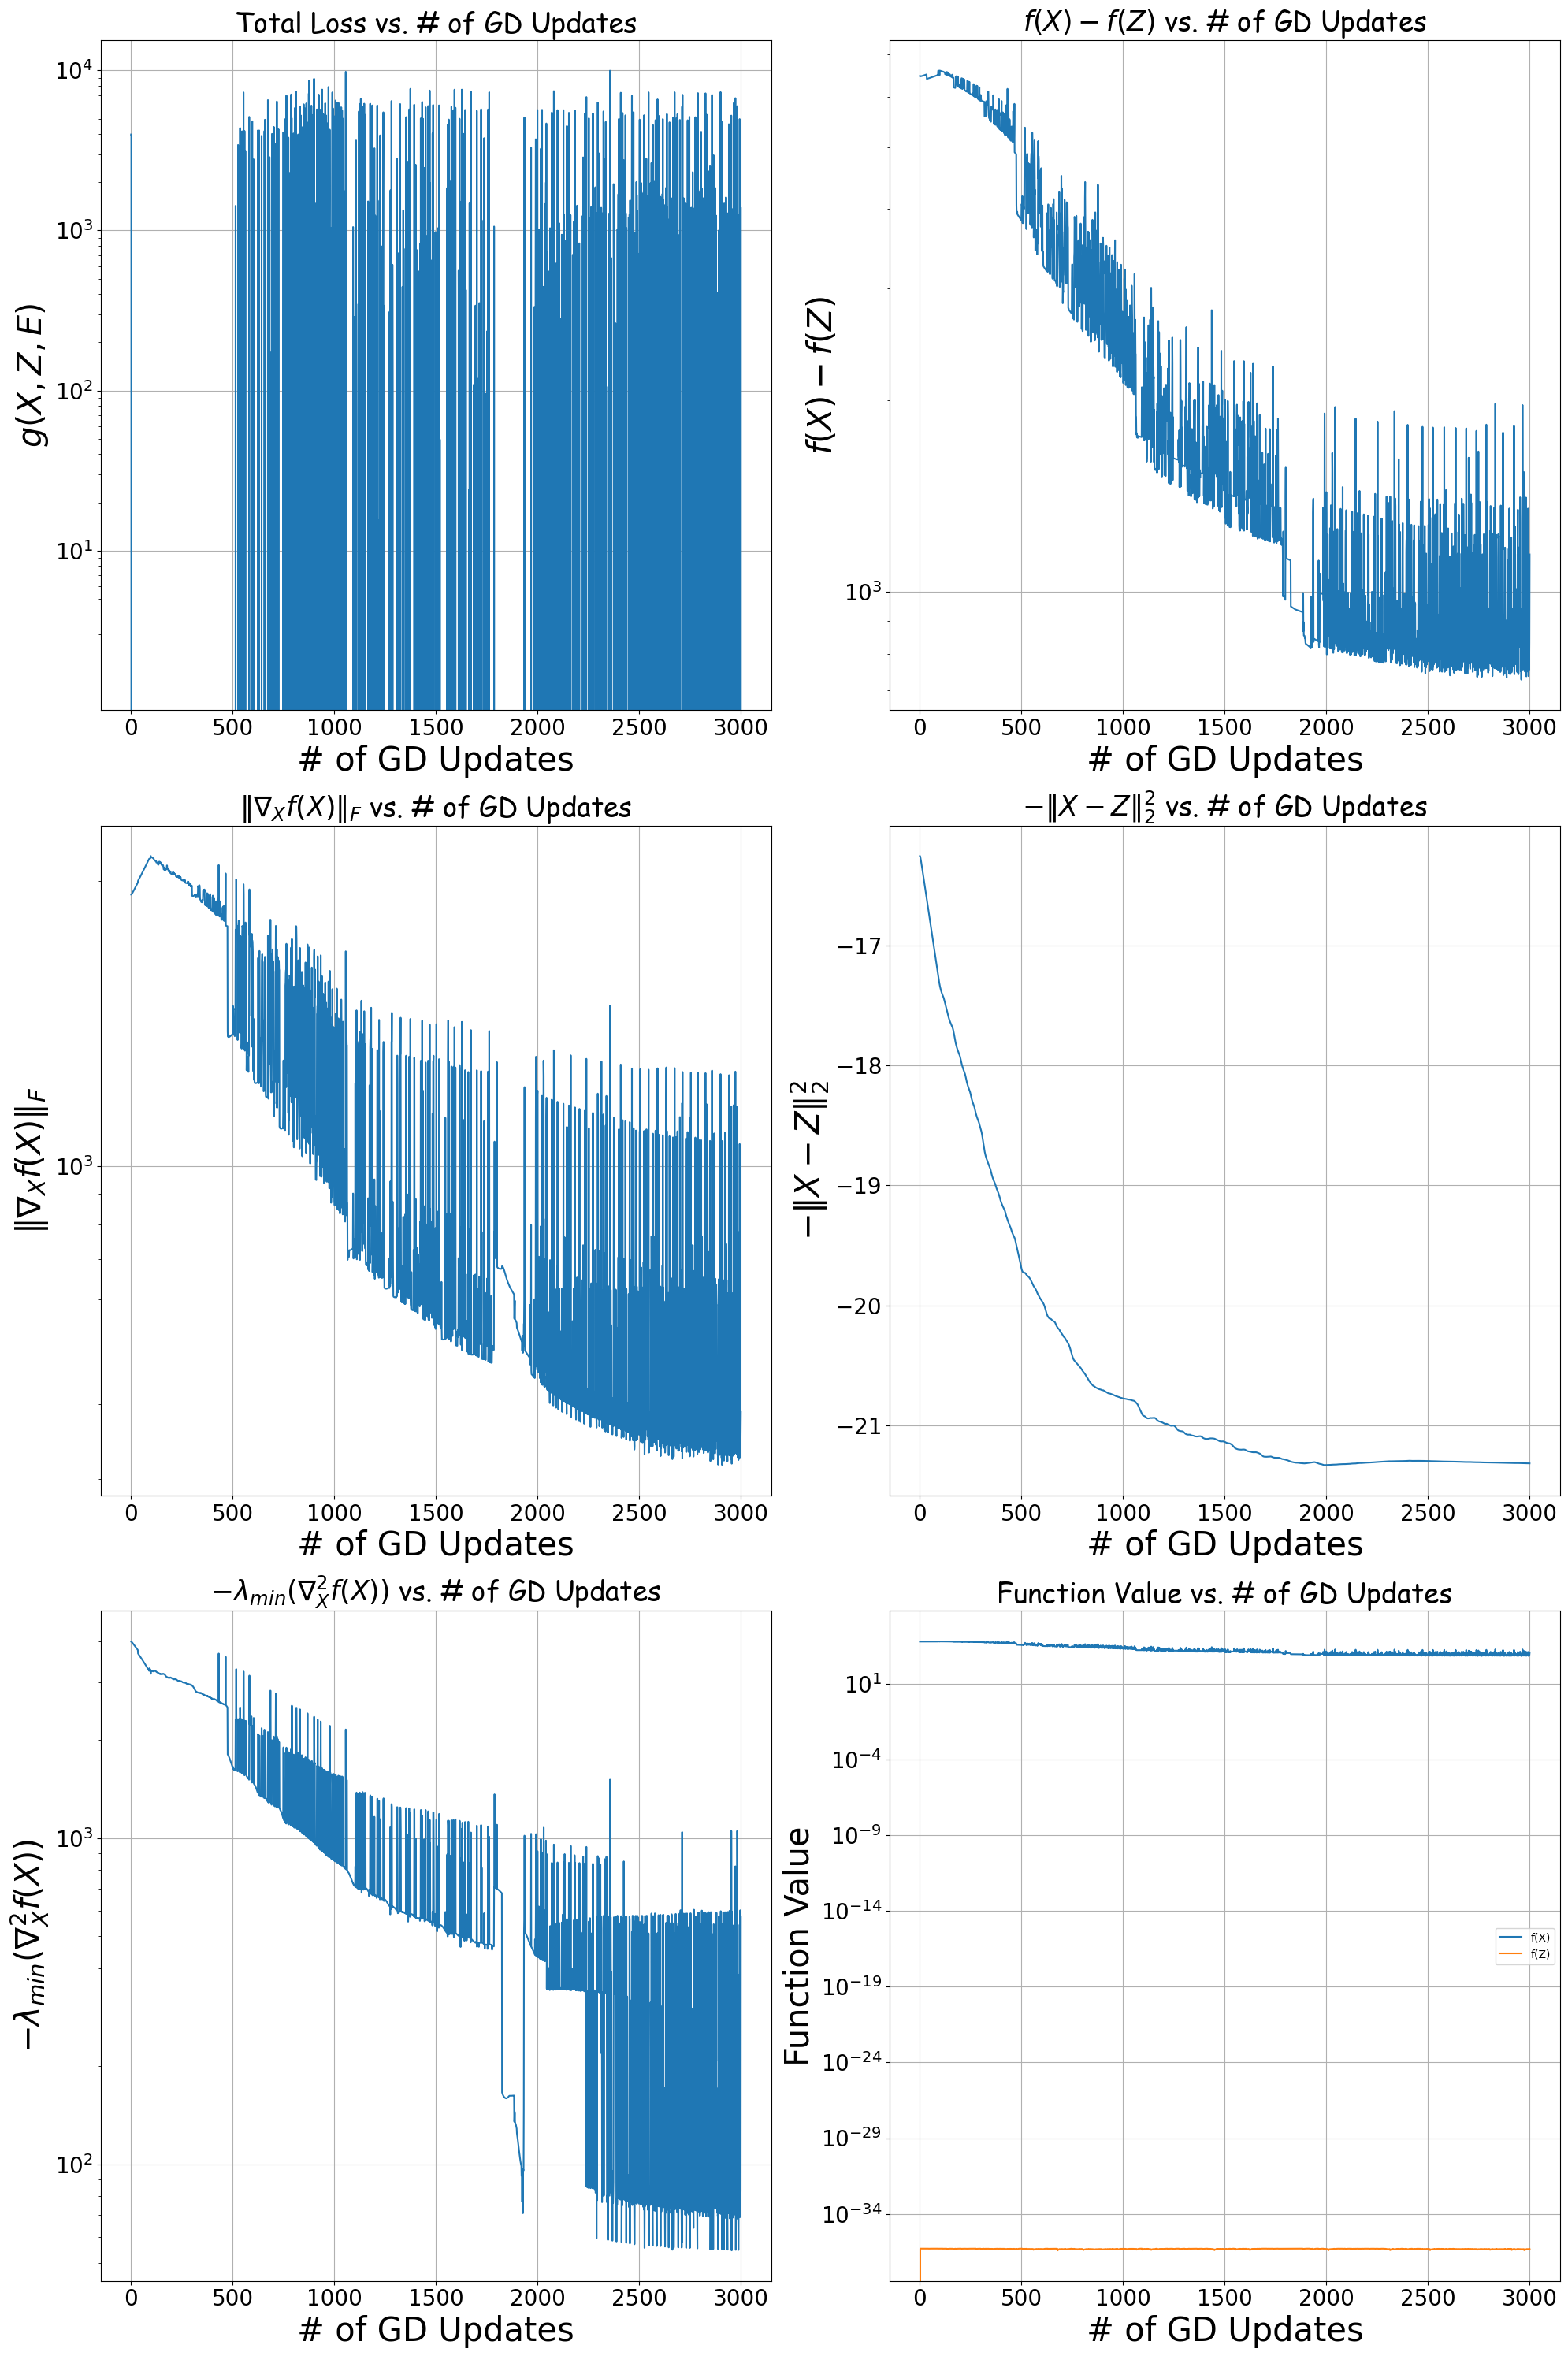

In [9]:
####### 14-bus Example (Search for X, Z, P) #######
top_k       = 75        # 1 ~ 122
e_norm      = 1e-18 
device      = 'cuda:0' if torch.cuda.is_available() else 'cpu'
loss_type   = 'PSSE_max'
optim       = 'AdamW'
iters       = 3000
lr          = 5e-4
min_lr      = 5e-5
lr_sched    = 'cosine'
T           = 1.5
trans_bound = (-0.1, -5e1)
same_seed(0)
Mats, z = extract_measurement() # Extract the measurement matrix and the ground truth voltages
A = create_P(Mats)
variables = {
    "X": None,
    "Z": None,
    "e": None,
    "P": None,
}

parameters, losses = search_counter(
    variables,
    top_k, 
    e_norm, 
    A,
    loss_type, 
    optim, 
    iters, 
    lr, 
    min_lr,
    lr_sched, 
    T,
    trans_bound
)
print_busses("14-bus Example (Search for X, Z, P)", parameters)
plot_loss(losses)

In [6]:
def DSE(top_k, search_loops, e_norm, busses=2, loss_type='PSSE_max', optim='Adam', iters=100, lr=0.001, min_lr=5e-5, lr_sched='cosine', T=1, trans_bound=(-1, -1e2)):
    same_seed(0)
    for i in range(search_loops):
        if busses == 2:
            A_np = load_mat_data("data/2bus_data.mat")
            A = torch.tensor(np.moveaxis(A_np.reshape(3,3,10), -1, 0), dtype=torch.float64)
        elif busses == 14:
            Mats, z = extract_measurement()
            A = create_P(Mats)
        else:
            raise NotImplementedError
        # Search for (X, Z, e)
        P = torch.tensor([1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0], dtype=torch.float64)
        variables = {
            "X": None,
            "Z": None,
            "e": None,
            "P": P,
        }
        parameters, losses = search_counter(
            variables,
            top_k, 
            e_norm, 
            A,
            loss_type, 
            optim, 
            iters, 
            lr, 
            min_lr,
            lr_sched, 
            T,
            trans_bound
        )
        if len(losses) < iters + 1: # Early Stop
            continue
        flag = check_PSSE(
            parameters['X'], 
            A, 
            parameters['Z'],
            P,
            top_k,
        )
        if flag:
            print(f"================== Search Iteration : {i} ==================")
            print(f"{'=> Total loss':<27} {'=':^1} {losses[-1][0]:>10.2e}")
            print(f"{'=> f(Z) - f(X)':<27} {'=':^1} {losses[-1][1]:>10.2e}")
            print(f"{'=> |gradient(X)|':<27} {'=':^1} {losses[-1][2]:>10.2e}")
            print(f"{'=> -lambda_min(hessian(X))':<27} {'=':^1} {losses[-1][3]:>10.2e}")
            print(f"{'=> |XX^T-ZZ^T|_F':<27} {'=':^1} {losses[-1][6]:>10.2e}")
            print(f"{'=> |X-Z|_F':<27} {'=':^1} {torch.linalg.norm(parameters['X'] - parameters['Z'], ord='fro'):>10.2e}")
            print_busses("", parameters)

In [7]:
top_k       = 3        # 1 ~ 122 or 1 ~ 10
e_norm      = 1e-18 
loss_type   = 'PSSE_max'
optim       = 'Adam'
iters       = 10000
lr          = 5e-4
min_lr      = 5e-5
lr_sched    = 'cosine'
T           = 1.5
trans_bound = (-1, -5e1)
busses      = 2
search_loops = 10

DSE(top_k, search_loops, e_norm, busses, loss_type, optim, iters, lr, min_lr, lr_sched, T, trans_bound)

================== Search Iteration : 0 ==================
=> Total loss               =  -4.86e+02
=> f(Z) - f(X)              =  -2.66e+01
=> |gradient(X)|            =   1.75e+02
=> -lambda_min(hessian(X))  =  -6.35e+01
=> |XX^T-ZZ^T|_F            =  -1.70e+00
=> |X-Z|_F                  =   6.78e-01
====================  ====================
=> X
Bus-0: mag = 0.8000, ang = 0.00
Bus-1: mag = 0.9475, ang = -86.30
=> Z
Bus-0: mag = 0.8000, ang = 0.00
Bus-1: mag = 1.2000, ang = -52.00


================== Search Iteration : 1 ==================
=> Total loss               =  -1.30e+02
=> f(Z) - f(X)              =  -3.88e+01
=> |gradient(X)|            =   1.27e+02
=> -lambda_min(hessian(X))  =   6.80e-01
=> |XX^T-ZZ^T|_F            =  -1.61e+00
=> |X-Z|_F                  =   2.95e-03
====================  ====================
=> X
Bus-0: mag = 0.8018, ang = 0.00
Bus-1: mag = 0.8377, ang = 18.10
=> Z
Bus-0: mag = 0.8000, ang = 0.00
Bus-1: mag = 0.8358, ang = 18.19


KeyboardInterrupt: 

In [ ]:
def generate_data(t_res, N_res, repeat=4, iters=10000, lr=0.0001, lr_sched='static', optim='SGD', device='cpu'):
    proj_fn = create_proj_fn('PSSE')
    Mats, z = extract_measurement()
    n = z.shape[0] * 2 - 1
    m = len(Mats)
    P = create_P(Mats)
    z_rect = torch.tensor(np.concatenate([z.real, z.imag]), dtype=torch.float64)
    
    x_axis = np.arange(0.1, 1, t_res)
    y_axis = np.arange(n, m, N_res)
    grad_norms, success = np.zeros((len(x_axis), len(y_axis), repeat)), np.zeros((len(x_axis), len(y_axis), repeat))
    for i, t in enumerate(x_axis):
        for j, N in enumerate(y_axis):
            for rep in range(repeat):
                criterion = create_loss_fn('PSSE_1', P=P[:N], z=z_rect)
                x_0 = PSSE_initialization(z, t)
                x_rect = torch.tensor(np.concatenate([x_0.real, x_0.imag]), requires_grad=True, dtype=torch.float64).to(device)
                proj_fn(x_rect)
                parameters = [x_rect]
                _, grad_norm, _ = sgd(
                    parameters, 
                    criterion,
                    proj_fn,
                    optim, 
                    iters, 
                    lr,
                    lr_sched,
                )
                error_norm = torch.linalg.norm(parameters[0].detach() - z_rect, ord='fro')
                # print(t, N, error_norm)
                if error_norm < 1e-9:
                    success[i][j][rep] += 1
                grad_norms[i][j][rep] += grad_norm
    
    avg_grad_norm = np.average(grad_norms, axis=-1)
    success_rate = np.average(success, axis=-1)

    return x_axis, y_axis, avg_grad_norm, success_rate 
    

In [ ]:
def plot_color(x_axis, y_axis, avg_grad_norm, success_rate):
    fig, ax = plt.subplots(1, 2, figsize=(20, 10), tight_layout=True)
    print(success_rate.shape)
    print(x_axis.shape)
    print(y_axis.shape)
    X, Y = np.meshgrid(x_axis, y_axis)
    pcm = ax[0].pcolormesh(X, Y, success_rate.T, cmap='viridis', shading='nearest')
    fig.colorbar(pcm, ax=ax[0], label='Z-value')

In [ ]:
t_res       = 0.1
N_res       = 10
repeat      = 4
iters       = 30000
lr          = 0.0002
lr_sched    = 'cosine'
optim       = 'SGD'
device      = 'cuda:0' if torch.cuda.is_available() else 'cpu'

x_axis, y_axis, avg_grad_norm , sucess_rate = generate_data(t_res, N_res, repeat, iters, lr, lr_sched, optim, device)

In [ ]:
print(sucess_rate)
plot_color(x_axis, y_axis, avg_grad_norm, sucess_rate)